<a href="https://colab.research.google.com/github/rhoadesScholar/JeffsMatland/blob/master/synapseScratchWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import os
import numpy as np
import zarr
import matplotlib.pyplot as plt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage import measure
from skimage import segmentation
from scipy import ndimage
import daisy
from PIL import Image
from scipy.ndimage import zoom
# %gui qt
# %gui
# %gui wx
from mayavi import mlab 
# mlab.init_notebook()
mlab.init_notebook('png', 800, 800)

Notebook initialized with png backend.


In [ ]:
#INITIALIZE NOTEBOOK
jupyter nbextension install --py mayavi --user
jupyter nbextension enable --py mayavi --user

#MOUNT SERVER DRIVES
sudo sshfs -o allow_other,default_permissions jlr54@catmaid2.hms.harvard.edu:/home /home 
sudo sshfs -o allow_other,default_permissions jlr54@catmaid2.hms.harvard.edu:/n/groups/htem/ /n/groups/htem

#ZARR SHENANIGANS

In [ ]:
syn = zarr.open('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/outputs/2008/ml0/setup22_ds4_m_v3/530000/output.zarr', mode='r')
raw = zarr.open('/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_gt/synapse_gt/ml0/ml0.zarr/', mode='r')

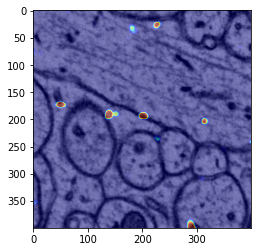

In [ ]:
plt.imshow(raw.volumes.raw[0,:400,:400], cmap='gray')
plt.imshow(syn.volumes.pred_syn_indicator[0,:400,:400], cmap='jet', alpha=0.5)

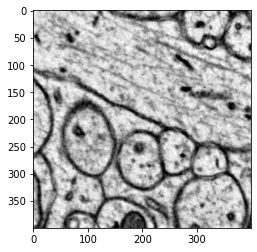

In [ ]:
plt.imshow(raw.volumes.raw[0,:400,:400], cmap='gray')

In [ ]:
syn.volumes.pred_syn_indicator.info

Name,/volumes/pred_syn_indicator
Type,zarr.core.Array
Data type,uint8
Shape,"(208, 458, 458)"
Chunk shape,"(102, 560, 560)"
Order,C
Read-only,True
Compressor,GZip(level=5)
Store type,zarr.storage.DirectoryStore
No. bytes,43630912 (41.6M)
No. bytes stored,1906007 (1.8M)


In [ ]:
import sys
sys.version_info >= (3,)

True

# Using Daisy

In [89]:
dataset = 'cb2'#CHANGE AS NEEDED
dataname = 'ml0'#CHANGE AS NEEDED
cleftFlag = False#CHANGE AS NEEDED

#'/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/gt/tmn7/'
rawD = daisy.open_ds('/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_gt/synapse_gt/'+dataname+'/'+dataname+'.zarr', 'volumes/raw')
if cleftFlag:
    cleftD = daisy.open_ds('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/outputs/2008/ml0/setup22_ds4_m_v3/530000/output.zarr', 'volumes/pred_syn_indicator')#CHANGE AS NEEDED

PathNotFoundError: ignored

In [75]:
fullSHAPE = daisy.Coordinate([5120, 6144, 6144])#CHANGE AS NEEDED
newOffset = rawD.roi.get_center() - fullSHAPE/2
roi = daisy.Roi(newOffset, tuple([rawD.voxel_size[0], fullSHAPE[1], fullSHAPE[2]]))
if cleftFlag:
  roi = roi.snap_to_grid(cleftD.voxel_size)#, mode='closest')
else:
  roi = roi.snap_to_grid(rawD.voxel_size, mode='closest')
print(str(roi.get_offset()))

(2440, 1328, 1328)


In [ ]:
assert False #don't run this again on accident

path = '/n/groups/htem/temcagt/datasets/cb2/segmentation/jeff/webknossos/'#CHANGE AS NEEDED
basename = dataname+'_syn_gt'#CHANGE AS NEEDED
if not os.path.exists(path+basename+'/raw/'):
    os.makedirs(path+basename+'/raw/')
if not os.path.exists(path+basename+'/segmentation/') and cleftFlag:
    os.makedirs(path+basename+'/segmentation/')
ext = '.tif'

fullSHAPE = daisy.Coordinate([5120, 6144, 6144])#CHANGE AS NEEDED
newOffset = rawD.roi.get_center() - fullSHAPE/2
roi = daisy.Roi(newOffset, tuple([rawD.voxel_size[0], fullSHAPE[1], fullSHAPE[2]]))
if cleftFlag:
    roi = roi.snap_to_grid(cleftD.voxel_size)#, mode='closest')
else:
    roi = roi.snap_to_grid(rawD.voxel_size, mode='closest')
tifCount = int(fullSHAPE[0] / rawD.voxel_size[0])
shift = daisy.Coordinate((rawD.voxel_size[0], 0, 0))

print(roi.get_offset())

#untested saving of offset file
offsetFile = open(r path+basename,"w+")
offsetFile.write(str(roi.get_offset()))
offsetFile.close()

for i in range(tifCount):
    Image.fromarray(np.squeeze(rawD.to_ndarray(roi=roi))).save(path+basename+'/raw/raw_'+str(i)+ext)
    if cleftFlag:
        cleftIm = zoom(np.squeeze(cleftD.to_ndarray(roi=roi))>0, (cleftD.voxel_size/rawD.voxel_size)[1:])
        Image.fromarray(cleftIm).save(path+basename+'/segmentation/segmentation'+str(i)+ext)
    roi = roi.shift(shift)

# Make Webknossos Files

In [ ]:
def getCuberCmd(dataset, basename, path):
    # basename = 'cutout1_syn_gt'
    cmdStr = 'python -m wkcuber --layer_name color --scale 4,4,40 --name '
    cmdStr += dataset+'_'+basename+' '
    cmdStr += path+basename+'/raw/ '
    cmdStr += path+basename+'/'+dataset+'_'+basename
    print(cmdStr)

In [ ]:
def getZip(dataset, basename, path):
    zipStr = 'zip -v -r '+path+basename+'/'+dataset+'_'+basename+'.zip '
    zipStr += path+basename+'/'+dataset+'_'+basename
    print(zipStr)

In [ ]:
def getPermitCmd(basename, path):
  perStr = 'chmod -R 777 '
  perStr += path+basename
  print(perStr)

def getCopyCmd(dataset, basename, fromPath, toPath):
  cpyStr = 'cp -vupR '
  cpyStr += fromPath+basename+'/'+dataset+'_'+basename
  cpyStr += ' '+toPath
  print(cpyStr)

In [ ]:
#GENERATE COMMANDS TO UPDATE WEBKNOSSOS WORKING DIRECTORIES WITH NEW DATAS (for pasting into catmaid2 server terminal session)
serverPath = '/home/jlr54/webknossos/binaryData/harvard-htem/'
backupPath = '/n/groups/htem/webknossos/binaryData/harvard-htem/'
dirs = os.listdir(path)
for dir in dirs:
  permitDo = False
  if not any(['datasource-properties.json' in fs for fs in os.listdir(path+dir+'/'+dataset+'_'+dir)]):
    basename = dir
    getCuberCmd(dataset, basename, path)
    permitDo = True
  if not any(['zip' in fs for fs in os.listdir(path+'/'+dir)]):
    getZip(dataset, basename, path)
    permitDo = True
  if permitDo:
    getPermitCmd(basename, path)
  if not any([dataset+'_'+dir in fs for fs in os.listdir(serverPath)]):
    getCopyCmd(dataset, basename, path, serverPath)

In [ ]:
dirs = os.listdir(path)
# dirs = os.listdir(path+basename+'/'+dataset+'_'+basename)
dir = dirs[0]
print(dataset+'_'+dir)
print([dataset+'_'+dir in fs for fs in os.listdir(serverPath)])

cb2_cutout6_syn_gt
[False, False, False, False, True, False, False, False, False, False, False, False, False, False, False]


In [ ]:
#update webknossos server data backup:
print('\n sudo cp -fuRv /home/jlr54/webknossos/* /n/groups/htem/webknossos')

# Playing with Daisy Masks

In [76]:
volName = 'volumes/labels/cleft_255'

def getGTzarr():
  for d1 in os.listdir(path='/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_gt/'+dataname):
    if '.zarr' in d1 and os.path.isdir('/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_gt/'+dataname+'/'+d1+'/'+volName):
      return '/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_gt/'+dataname+'/'+d1#+'/volumes/labels/cleft'

print(getGTzarr())

/n/groups/htem/temcagt/datasets/cb2/segmentation/tri/cb2_gt/ml0/ml0_setup45.zarr


In [77]:
# newCleft = daisy.open_ds(getGTzarr(), volName)
newCleft = daisy.open_ds('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/outputs/2008/ml0/setup22_ds4_m_v3/530000/output.zarr', 'volumes/pred_syn_indicator')#CHANGE AS NEEDED
segs = daisy.open_ds('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/outputs/2010_m/ml0/setup52_ds2/315000/output.zarr', 'volumes/segmentation_0.700')
# newCleft.materialize()
# segs.materialize()
# rawD.materialize()

In [79]:
n = 50
# cleftD.voxel_size/rawD.voxel_size
print(rawD.roi)
print(newCleft.roi)
print(segs.roi)
segdROI = rawD.roi.intersect(segs.roi.intersect(newCleft.roi))
testROI = daisy.Roi(segdROI.get_offset(), 
                    np.append(
                        max([rawD.voxel_size[0], newCleft.voxel_size[0], segs.voxel_size[0]])*3, 
                        segdROI.get_shape()[1:]))
print(testROI)
print(f'Raw: {rawD.voxel_size}')
print(f'Segs: {segs.voxel_size}')
print(f'Cleft: {newCleft.voxel_size}')
print((np.array(newCleft.voxel_size)/np.array(rawD.voxel_size)))
# print(6000/cleftD.voxel_size[0], 6000/cleftD.voxel_size[1], 6000/cleftD.voxel_size[2])
# rawList

[0:10000, 0:8800, 0:8800] (10000, 8800, 8800)
[840:9160, 736:8064, 736:8064] (8320, 7328, 7328)
[720:9280, 848:7952, 848:7952] (8560, 7104, 7104)
[840:960, 848:7952, 848:7952] (120, 7104, 7104)
Raw: (40, 4, 4)
Segs: (40, 8, 8)
Cleft: (40, 16, 16)
[1. 4. 4.]


In [44]:
# testRaw = np.squeeze(rawD.to_ndarray(testROI))

In [45]:
testSeg = np.squeeze(segs.to_ndarray(testROI))

In [46]:
testCleft = np.squeeze(newCleft.to_ndarray(testROI))

In [68]:
testSegResized = zoom(testSeg, (segs.voxel_size/rawD.voxel_size), order=0)
testCleftResized = zoom(testCleft, (np.array(newCleft.voxel_size)/np.array(rawD.voxel_size)), order=0)

In [ ]:
# extent = [0, rawD.to_ndarray(roi).shape[1], 0, rawD.to_ndarray(roi).shape[1]]
fig = plt.figure(frameon=False, figsize=[10,10])
# plt.imshow(testRaw, cmap='gray')
# plt.imshow(testCleft, cmap='gray')
plt.imshow(testSegResized, alpha=0.5, cmap='tab20')
plt.imshow(testCleftResized, alpha=0.5, cmap='gray')

In [69]:
labels, _ = ndimage.label(testCleftResized >= 128)
syns = measure.regionprops(labels, testCleftResized)
i = np.argmax([syn['area'] for syn in syns])
this_syn = syns[i]
bbox = this_syn['bbox']
print(bbox)
# this_seg = testSegResized[bbox[0]:bbox[2], bbox[1]:bbox[3]]
this_seg = testSegResized[bbox[0]:bbox[3], bbox[1]:bbox[4], bbox[2]:bbox[5]]
# this_seg = np.ones(this_seg.shape) + np.triu(np.ones(this_seg.shape))
# this_seg = np.ones((50, 50)) + np.concatenate((np.ones((25, 50)), np.zeros((25, 50))))

(0, 1521, 1104, 3, 1621, 1172)



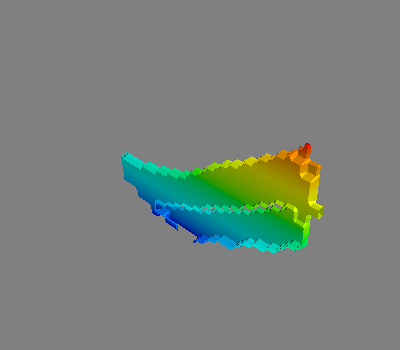

In [70]:
# bin = test == 37683405
test = segmentation.find_boundaries(this_seg, connectivity=this_seg.ndim)
# test2 = np.ma.masked_array(test == False, this_syn.image == 0)
test[this_syn.image == 0] = False
verts, faces, normals, values = measure.marching_cubes_lewiner(test, spacing=newCleft.voxel_size)
synapse = mlab.triangular_mesh([vert[0] for vert in verts],
                      [vert[1] for vert in verts],
                      [vert[2] for vert in verts],
                      faces) 
synapse

In [71]:
area = measure.mesh_surface_area(verts, faces) / 1000**2
print(f'Surface area of synapse: {area} microns\u00b2')

Surface area of synapse: 0.8534667095737286 microns²


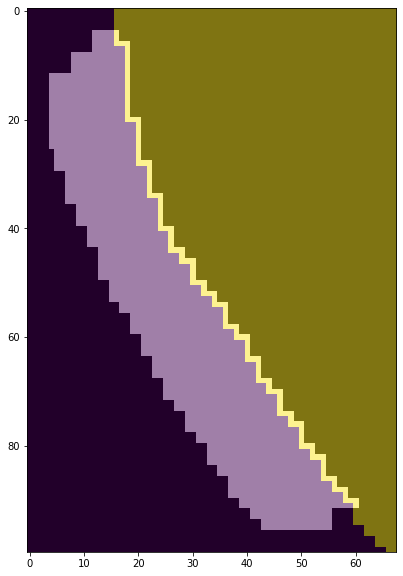

In [66]:
i = 0
fig = plt.figure(frameon=False, figsize=[10,10])
plt.imshow(this_seg[i,:,:])
# plt.imshow(this_syn.image[i,:,:], cmap='gray', alpha=.5)
plt.imshow(test[i,:,:], cmap='gray', alpha=.5)
# plt.colorbar()

In [87]:
a = tuple((1, 2, 3))
b = ['hello', 1, 2, 3]
# b.pop(0)
np.array(a)-np.array(b)
np.mean(b)

UFuncTypeError: ignored

In [556]:
test.sum()/2

132.0

In [567]:
a = np.array([1,2,3,4,5,6]).reshape((2, 3))
for x,y,z in a:
  print(f'{x}, {y}, {z}')

1, 2, 3
4, 5, 6
